In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 43.9 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt

In [ ]:
df = yf.download('AAPL', start='2020-01-01', end='2021-01-01')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.06,75.15,73.80,75.09,73.99,135480400
2020-01-03,74.29,75.14,74.12,74.36,73.27,146322800
2020-01-06,73.45,74.99,73.19,74.95,73.85,118387200
2020-01-07,74.96,75.22,74.37,74.60,73.51,108872000
2020-01-08,74.29,76.11,74.29,75.80,74.69,132079200


In [ ]:
#bollinger band
w = 20
k = 2
df['center'] = df['Close'].rolling(w).mean()
df['sigma'] = df['Close'].rolling(w).std()
df['ub'] = df['center'] + k * df['sigma']
df['lb'] = df['center'] - k * df['sigma']
df.head()

,Open,High,Low,Close,Adj Close,Volume,center,sigma,ub,lb
Date,,,,,,,,,,
2020-01-02,74.06,75.15,73.80,75.09,73.99,135480400,nan,nan,nan,nan
2020-01-03,74.29,75.14,74.12,74.36,73.27,146322800,nan,nan,nan,nan
2020-01-06,73.45,74.99,73.19,74.95,73.85,118387200,nan,nan,nan,nan
2020-01-07,74.96,75.22,74.37,74.60,73.51,108872000,nan,nan,nan,nan
2020-01-08,74.29,76.11,74.29,75.80,74.69,132079200,nan,nan,nan,nan


In [ ]:
buy = 'D'
sell = 'A'

#band to signal
df['trade'] = np.nan
# buy
if buy == 'A':
    df['trade'].mask(df['Close']>df['ub'], 'buy', inplace=True)
elif buy == 'B':
    df['trade'].mask((df['ub']>df['Close']) & (df['Close']>df['center']), 'buy', inplace=True)
elif buy == 'C':
    df['trade'].mask((df['center']>df['Close']) & (df['Close']>df['lb']), 'buy', inplace=True)
elif buy == 'D':
    df['trade'].mask((df['lb']>df['Close']), 'buy', inplace=True)
# zero
if sell == 'A':
    df['trade'].mask(df['Close']>df['ub'], 'zero', inplace=True)
elif sell == 'B':
    df['trade'].mask((df['ub']>df['Close']) & (df['Close']>df['center']), 'zero', inplace=True)
elif sell == 'C':
    df['trade'].mask((df['center']>df['Close']) & (df['Close']>df['lb']), 'zero', inplace=True)
elif sell == 'D':
    df['trade'].mask((df['lb']>df['Close']), 'zero', inplace=True)
df['trade'].fillna(method='ffill', inplace=True)
df['trade'].fillna('zero', inplace=True)

df.tail()

,Open,High,Low,Close,Adj Close,Volume,center,sigma,ub,lb,trade
Date,,,,,,,,,,,
2020-12-24,131.32,133.46,131.10,131.97,131.16,54930100,124.90,4.19,133.28,116.52,zero
2020-12-28,133.99,137.34,133.51,136.69,135.85,124486200,125.91,4.49,134.89,116.93,zero
2020-12-29,138.05,138.79,134.34,134.87,134.04,121047300,126.70,4.61,135.92,117.48,zero
2020-12-30,135.58,135.99,133.40,133.72,132.90,96452100,127.25,4.77,136.78,117.72,zero
2020-12-31,134.08,134.74,131.72,132.69,131.88,99116600,127.73,4.81,137.34,118.12,zero


In [ ]:
#position
df['position'] = ''
df['position'].mask((df['trade'].shift(1)=='zero') & (df['trade']=='zero'), 'zz', inplace=True)
df['position'].mask((df['trade'].shift(1)=='zero') & (df['trade']=='buy'), 'zl', inplace=True)
df['position'].mask((df['trade'].shift(1)=='buy') & (df['trade']=='zero'), 'lz', inplace=True)
df['position'].mask((df['trade'].shift(1)=='buy') & (df['trade']=='buy'), 'll', inplace=True)
    
df['position_chart'] = 0
df['position_chart'].mask(df['trade']=='buy', 1, inplace=True)

df.tail()

,Open,High,Low,Close,Adj Close,Volume,center,sigma,ub,lb,trade,position,position_chart
Date,,,,,,,,,,,,,
2020-12-24,131.32,133.46,131.10,131.97,131.16,54930100,124.90,4.19,133.28,116.52,zero,zz,0
2020-12-28,133.99,137.34,133.51,136.69,135.85,124486200,125.91,4.49,134.89,116.93,zero,zz,0
2020-12-29,138.05,138.79,134.34,134.87,134.04,121047300,126.70,4.61,135.92,117.48,zero,zz,0
2020-12-30,135.58,135.99,133.40,133.72,132.90,96452100,127.25,4.77,136.78,117.72,zero,zz,0
2020-12-31,134.08,134.74,131.72,132.69,131.88,99116600,127.73,4.81,137.34,118.12,zero,zz,0


In [ ]:
#evaluate
cost = 0

df['signal_price'] = np.nan
df['signal_price'].mask(df['position']=='zl', df.iloc[:,0], inplace=True)
df['signal_price'].mask(df['position']=='lz', df.iloc[:,0], inplace=True)
record = df[['position','signal_price']].dropna()
record['rtn'] = 1
record['rtn'].mask(record['position']=='lz', (record['signal_price']*(1-cost))/record['signal_price'].shift(1), inplace=True)
record['acc_rtn'] = record['rtn'].cumprod()
df['signal_price'].mask(df['position']=='ll', df.iloc[:,0], inplace=True)
df['rtn'] = record['rtn']
df['rtn'].fillna(1, inplace=True)
df['daily_rtn'] = 1
df['daily_rtn'].mask(df['position'] == 'll', df['signal_price'] / df['signal_price'].shift(1), inplace=True)
df['daily_rtn'].mask(df['position'] == 'lz', (df['signal_price']*(1-cost)) / df['signal_price'].shift(1), inplace=True)
df['daily_rtn'].fillna(1, inplace=True)
df['acc_rtn'] = df['daily_rtn'].cumprod()
df['acc_rtn_dp'] = ((df['acc_rtn']-1)*100).round(2)
df['mdd'] = (df['acc_rtn'] / df['acc_rtn'].cummax()).round(4)
df['bm_mdd'] = (df.iloc[:, 0] / df.iloc[:, 0].cummax()).round(4)
df.drop(columns='signal_price', inplace=True)

df.tail()

,Open,High,Low,Close,Adj Close,Volume,center,sigma,ub,lb,trade,position,position_chart,rtn,daily_rtn,acc_rtn,acc_rtn_dp,mdd,bm_mdd
Date,,,,,,,,,,,,,,,,,,,
2020-12-24,131.32,133.46,131.10,131.97,131.16,54930100,124.90,4.19,133.28,116.52,zero,zz,0,1.00,1.00,1.03,3.49,1.00,0.95
2020-12-28,133.99,137.34,133.51,136.69,135.85,124486200,125.91,4.49,134.89,116.93,zero,zz,0,1.00,1.00,1.03,3.49,1.00,0.97
2020-12-29,138.05,138.79,134.34,134.87,134.04,121047300,126.70,4.61,135.92,117.48,zero,zz,0,1.00,1.00,1.03,3.49,1.00,1.00
2020-12-30,135.58,135.99,133.40,133.72,132.90,96452100,127.25,4.77,136.78,117.72,zero,zz,0,1.00,1.00,1.03,3.49,1.00,0.98
2020-12-31,134.08,134.74,131.72,132.69,131.88,99116600,127.73,4.81,137.34,118.12,zero,zz,0,1.00,1.00,1.03,3.49,1.00,0.97


In [ ]:
def __get_period(df):
    df.dropna(inplace=True)
    end_date = df.index[-1]
    start_date = df.index[0]
    days_between = (end_date - start_date).days
    return abs(days_between)

def __annualize(rate, period):
    if period < 360:
        rate = ((rate-1) / period * 365) + 1
    elif period > 365:
        rate = rate ** (365 / period)
    else:
        rate = rate
    return round(rate, 4)

In [ ]:
def __get_sharpe_ratio(df, rf_rate):
    period = __get_period(df)
    rf_rate_daily = rf_rate / 365 + 1
    df['exs_rtn_daily'] = df['daily_rtn'] - rf_rate_daily
    exs_rtn_annual = (__annualize(df['acc_rtn'][-1], period) - 1) - rf_rate
    exs_rtn_vol_annual = df['exs_rtn_daily'].std() * np.sqrt(365)
    sharpe_ratio = exs_rtn_annual / exs_rtn_vol_annual if exs_rtn_vol_annual>0 else 0
    return round(sharpe_ratio, 4)

In [ ]:
rst = {}
rst['no_trades'] = (df['position']=='zl').sum()
rst['no_win'] = (df['rtn']>1).sum()
rst['acc_rtn'] = df['acc_rtn'][-1].round(4)
rst['hit_ratio'] = round((df['rtn']>1).sum() / rst['no_trades'], 4) if rst['no_trades']>0 else 0
rst['avg_rtn'] = round(df[df['rtn']!=1]['rtn'].mean(), 4)
rst['period'] = __get_period(df)
rst['annual_rtn'] = __annualize(rst['acc_rtn'], rst['period'])
rst['bm_rtn'] = round(df.iloc[-1,0]/df.iloc[0,0], 4)
rst['sharpe_ratio'] = __get_sharpe_ratio(df, 0.01)
rst['mdd'] = df['mdd'].min()
rst['bm_mdd'] = df['bm_mdd'].min()

print('CAGR: {:.2%}'.format(rst['annual_rtn'] - 1))
print('Accumulated return: {:.2%}'.format(rst['acc_rtn'] - 1))
print('Average return: {:.2%}'.format(rst['avg_rtn'] - 1))
print('Benchmark return : {:.2%}'.format(rst['bm_rtn']-1))
print('Number of trades: {}'.format(rst['no_trades']))
print('Number of win: {}'.format(rst['no_win']))
print('Hit ratio: {:.2%}'.format(rst['hit_ratio']))
print('Investment period: {:.1f}yrs'.format(rst['period']/365))
print('Sharpe ratio: {:.2f}'.format(rst['sharpe_ratio']))
print('MDD: {:.2%}'.format(rst['mdd']-1))
print('Benchmark MDD: {:.2%}'.format(rst['bm_mdd']-1))

CAGR: 3.79%
Accumulated return: 3.49%
Average return: 2.03%
Benchmark return : 67.32%
Number of trades: 2
Number of win: 1
Hit ratio: 50.00%
Investment period: 0.9yrs
Sharpe ratio: 0.08
MDD: -24.89%
Benchmark MDD: -29.77%


In [ ]:
from matplotlib.ticker import ScalarFormatter, FixedLocator

ScalarFormatter().set_scientific(False)
font = 'NanumSquareRound, AppleGothic, Malgun Gothic, DejaVu Sans'
plt.style.use('bmh')
plt.rcParams['font.family'] = font
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['lines.antialiased'] = True
plt.rcParams['figure.figsize'] = [10.0, 5.0]
plt.rcParams['savefig.dpi'] = 96
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.formatter.useoffset'] = True
plt.rcParams['axes.formatter.use_mathtext'] = True

In [ ]:
#chart


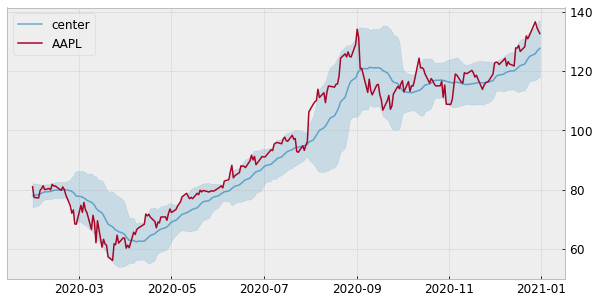

In [ ]:
#band chart
band = ['lb','center','ub']

fig, ax1 = plt.subplots()
x = df.index
ax1.axes.yaxis.set_visible(False)
# secondary y
ax2 = ax1.twinx()

ax2.fill_between(x, df[band[0]], df[band[2]], color='C0', alpha=.2)
ax2.plot(x, df[band[1]], label=band[1], color='C0', alpha=.7)
ax2.plot(x, df['Close'], label='AAPL', color='C1', alpha=1)
ax1.grid(False, axis='y')

ax2.legend(loc=2)

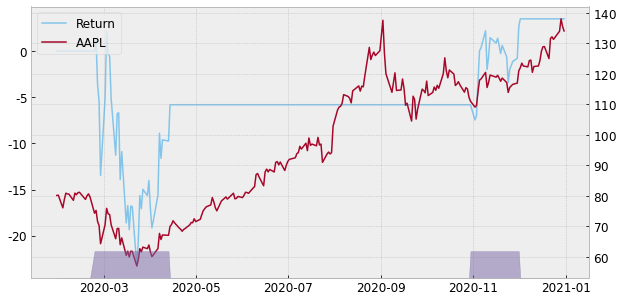

In [ ]:
#trade results
fig, ax1 = plt.subplots()
x = df.index
ax1.plot(x, df['acc_rtn_dp'], label='Return', color='C6', alpha=.7)
ax1.grid(False, axis='y')
# secondary y
ax2 = ax1.twinx()
ax2.plot(x, df.iloc[:,0], label=df.Close, color='C1', alpha=1)
ax1.plot(np.nan, label='AAPL', color='C1')
# 3rd y
ax3 = ax1.twinx()
ax3.fill_between(x, 0, df['position_chart'], color='C2', alpha=.5)
ax3.set_ylim(0, 10)
ax3.axes.yaxis.set_visible(False)
ax1.legend(loc=2)
# plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

In [ ]:
df = yf.download('AAPL', start='2020-01-01', end='2021-01-01')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.06,75.15,73.80,75.09,73.99,135480400
2020-01-03,74.29,75.14,74.12,74.36,73.27,146322800
2020-01-06,73.45,74.99,73.19,74.95,73.85,118387200
2020-01-07,74.96,75.22,74.37,74.60,73.51,108872000
2020-01-08,74.29,76.11,74.29,75.80,74.69,132079200


In [ ]:
symbol = df.columns[0]
df['ema_short'] = df[symbol].ewm(span=short).mean()
df['ema_long'] = df[symbol].ewm(span=long).mean()
df['macd'] = (df['ema_short'] - df['ema_long']).round(2)
df['macd_signal'] = df['macd'].ewm(span=signal).mean().round(2)
df['macd_oscillator'] = (df['macd'] - df['macd_signal']).round(2)

,Open,High,Low,Close,Adj Close,Volume,fast_k,slow_k,slow_d
Date,,,,,,,,,
2020-12-24,131.32,133.46,131.10,131.97,131.16,54930100,82.89,80.32,80.24
2020-12-28,133.99,137.34,133.51,136.69,135.85,124486200,96.22,84.97,82.18
2020-12-29,138.05,138.79,134.34,134.87,134.04,121047300,78.97,86.03,83.77
2020-12-30,135.58,135.99,133.40,133.72,132.90,96452100,72.80,82.66,84.55
2020-12-31,134.08,134.74,131.72,132.69,131.88,99116600,66.56,72.78,80.49
